In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit #funkcja dopasowująca model matematyczny do danych


# Definiujemy funkcję logistyczną (krzywą wzrostu)
def growth_curve(t, k, a, b):
    """
    Funkcja logistyczna modelująca skumulowany wzrost
    t: zmienna czasowa (numer miesiąca)
    k: maksymalna wartość (asymptota)
    a: współczynnik wzrostu
    b: parametr przesunięcia
    """
    return k / (1 + b * np.exp(-a * t))


data = pd.DataFrame({
    'miesiac': range(1, 94), 
    'liczba_bledow': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 0, 3, 1, 1, 0, 1, 0, 2,
                      10, 0, 16, 0, 2, 2, 1, 1, 1, 0, 3, 2, 1, 6, 3, 0, 1, 1, 0, 0, 14, 1, 4, 1, 1, 7, 14, 6, 0,
                      1, 2, 19, 7, 2, 5, 1, 12, 4, 6, 4, 7, 2, 2, 3, 8, 4, 6, 3, 3, 5, 8, 0, 6, 5, 10, 0, 5, 1, 2, 1, 2,
                      1, 0]
})

data['suma_bledow'] = data['liczba_bledow'].cumsum() #suma skumulowana
print(data['suma_bledow'])

0       1
1       1
2       1
3       1
4       1
     ... 
88    260
89    261
90    263
91    264
92    264
Name: suma_bledow, Length: 93, dtype: int64


Wartości początkowe: K=264.00, a=0.10, b=62.00
Dopasowane parametry: K=310.38, a=0.068681, b=91.34


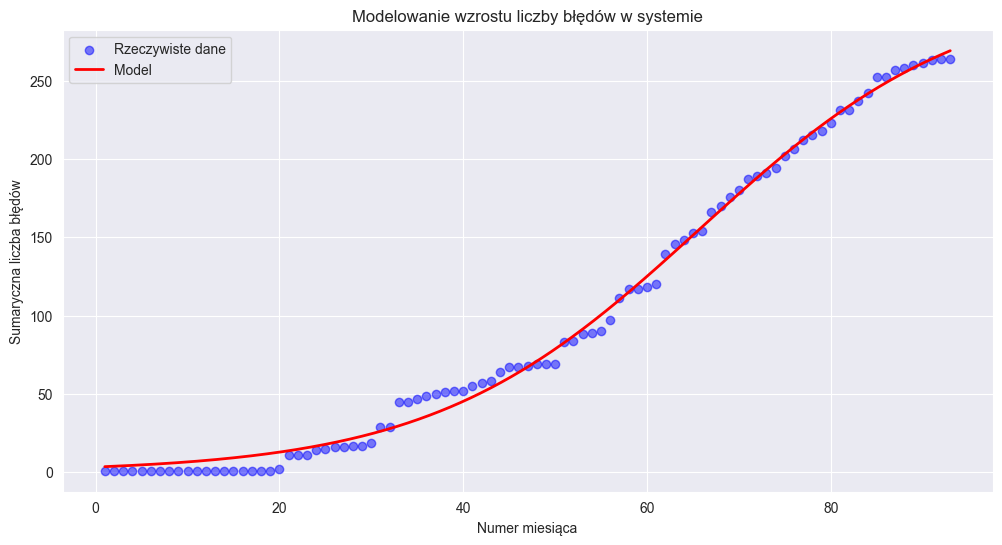

In [38]:
# Automatyczne wyznaczenie wartości początkowych
k_init = data['suma_bledow'].max()  #Maksymalna liczba błędów jako przybliżenie K
a_init = 0.1  #Początkowa wartość tempa wzrostu
b_init = data['miesiac'][data['suma_bledow'] > (k_init / 2)].iloc[0]  #Połowa wartości K jako przesunięcie

p0 = [k_init, a_init, b_init]
print(f"Wartości początkowe: K={k_init:.2f}, a={a_init:.2f}, b={b_init:.2f}")

#Dopasowanie modelu -> popt = optimized parameters
popt, _ = curve_fit(growth_curve, data['miesiac'], data['suma_bledow'], p0=p0, bounds=([0, 0, 0], [1000, 1, 1000]))
k, a, b = popt
print(f"Dopasowane parametry: K={k:.2f}, a={a:.6f}, b={b:.2f}")

plt.figure(figsize=(12, 6))
plt.scatter(data['miesiac'], data['suma_bledow'], label='Rzeczywiste dane', color='blue', alpha=0.5)
t = np.linspace(1, 93, 1000)
plt.plot(t, growth_curve(t, k, a, b), 'r-', label='Model', linewidth=2)
plt.xlabel('Numer miesiąca')
plt.ylabel('Sumaryczna liczba błędów')
plt.title('Modelowanie wzrostu liczby błędów w systemie')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
train_size = int(len(data) * 0.8)  # 80% danych do treningu
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# Dopasowanie modelu na zbiorze treningowym
popt, _ = curve_fit(growth_curve, train['miesiac'], train['suma_bledow'], p0=[300, 0.1, 90])

#Przewidywanie na zbiorze treningowym
predicted_train = growth_curve(train['miesiac'], *popt)
mse_train = np.mean((train['suma_bledow'] - predicted_train) ** 2)
print(f"Błąd średniokwadratowy (MSE) dla zbioru treningowego: {mse_train:.2f}")

#Przewidywanie na zbiorze testowym
predicted_test = growth_curve(test['miesiac'], *popt)
mse_test = np.mean((test['suma_bledow'] - predicted_test) ** 2)
print(f"Błąd średniokwadratowy (MSE) dla zbioru testowego: {mse_test:.2f}")

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

r2_test = r2_score(test['suma_bledow'], predicted_test)
print(f"Współczynnik determinacji (R^2) dla zbioru testowego: {r2_test:.4f}")


Błąd średniokwadratowy (MSE) dla zbioru treningowego: 42.90
Błąd średniokwadratowy (MSE) dla zbioru testowego: 16.63
Współczynnik determinacji (R^2) dla zbioru testowego: 0.9623


# Podejście z agregacją danych

In [40]:
data['kwartal'] = (data['miesiac'] - 1) // 3 + 1

# Agregacja danych według kwartałów
data_agg = data.groupby('kwartal').agg({
    'liczba_bledow': 'sum',        # Suma błędów w każdym kwartale
    'suma_bledow': 'last'          # Ostatnia wartość skumulowana w kwartale
}).reset_index()

print(data_agg)


    kwartal  liczba_bledow  suma_bledow
0         1              1            1
1         2              0            1
2         3              0            1
3         4              0            1
4         5              0            1
5         6              0            1
6         7             10           11
7         8              3           14
8         9              2           16
9        10              3           19
10       11             26           45
11       12              4           49
12       13              3           52
13       14              5           57
14       15             10           67
15       16              2           69
16       17             14           83
17       18              6           89
18       19             22          111
19       20              7          118
20       21             28          146
21       22              8          154
22       23             22          176
23       24             13          189


In [41]:
# Automatyczne wyznaczenie wartości początkowych dla danych zagregowanych
k_init = data_agg['suma_bledow'].max()  
a_init = 0.1 

# Znalezienie b_init jako punktu, w którym liczba błędów przekracza połowę wartości K
b_init_index = (data_agg['suma_bledow'] > (k_init / 2)).idxmax() #zwraca index
b_init = data_agg['kwartal'].iloc[b_init_index]  # Punkt odpowiadający połowie K

p0 = [k_init, a_init, b_init] 
print(f"Wartości początkowe (dane zagregowane): K={k_init:.2f}, a={a_init:.2f}, b={b_init:.2f}")

popt, _ = curve_fit(growth_curve, data_agg['kwartal'], data_agg['suma_bledow'], p0=p0, bounds=([0, 0, 0], [1000, 1, 1000]))
k, a, b = popt
print(f"Dopasowane parametry (dane zagregowane): K={k:.2f}, a={a:.6f}, b={b:.2f}")


Wartości początkowe (dane zagregowane): K=264.00, a=0.10, b=21.00
Dopasowane parametry (dane zagregowane): K=309.76, a=0.204417, b=86.99


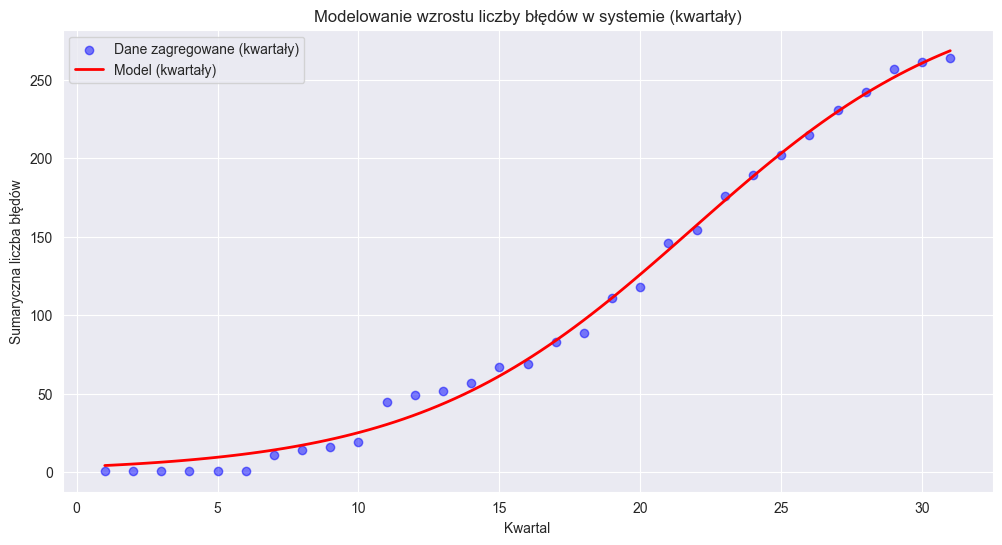

In [42]:
# Przewidywanie dla danych kwartalnych
t_agg = np.linspace(1, data_agg['kwartal'].max(), 100)
predicted_agg = growth_curve(t_agg, *popt)

plt.figure(figsize=(12, 6))
plt.scatter(data_agg['kwartal'], data_agg['suma_bledow'], label='Dane zagregowane (kwartały)', color='blue', alpha=0.5)
plt.plot(t_agg, predicted_agg, 'r-', label='Model (kwartały)', linewidth=2)
plt.xlabel('Kwartal')
plt.ylabel('Sumaryczna liczba błędów')
plt.title('Modelowanie wzrostu liczby błędów w systemie (kwartały)')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
train_size_agg = int(len(data_agg) * 0.8)  # 80% danych do treningu
train_agg = data_agg.iloc[:train_size_agg]
test_agg = data_agg.iloc[train_size_agg:]

popt, _ = curve_fit(growth_curve, train_agg['kwartal'], train_agg['suma_bledow'], p0=[300, 0.1, 90])

predicted_train_agg = growth_curve(train_agg['kwartal'], *popt)
mse_train_agg = np.mean((train_agg['suma_bledow'] - predicted_train_agg) ** 2)
print(f"Błąd średniokwadratowy (MSE) dla zbioru treningowego: {mse_train:.2f}")

predicted_test_agg = growth_curve(test_agg['kwartal'], *popt)
mse_test_agg = np.mean((test_agg['suma_bledow'] - predicted_test_agg) ** 2)
print(f"Błąd średniokwadratowy (MSE) dla zbioru testowego: {mse_test_agg:.2f}")

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

r2_test_agg = r2_score(test_agg['suma_bledow'], predicted_test_agg)
print(f"Współczynnik determinacji (R^2) dla zbioru testowego: {r2_test_agg:.4f}")


Błąd średniokwadratowy (MSE) dla zbioru treningowego: 42.90
Błąd średniokwadratowy (MSE) dla zbioru testowego: 15.71
Współczynnik determinacji (R^2) dla zbioru testowego: 0.9681
